# sim_flip baseline 


In [ ]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# --- Make local package imports work when running this notebook directly ---
REPO_ROOT = Path.cwd().parents[1]  # .../sim_flip/scripts -> repo root
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from sim_flip.src.dynamics import make_event_theta_deg, simulate  

In [10]:
# --- Publication-style Matplotlib defaults (tweak here) ---
mpl.rcParams.update({
    "figure.dpi": 130,
    "savefig.dpi": 300,
    "figure.figsize": (7.2, 4.2),
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 2.0,
})

def _finalize_ax(ax: plt.Axes, *, title: str | None = None) -> None:
    if title:
        ax.set_title(title)
    ax.grid(True, which="major", alpha=mpl.rcParams["grid.alpha"])
    ax.margins(x=0)

def first_crossing_time(t: np.ndarray, y: np.ndarray, threshold: float) -> float:
    """Linear-interpolated first time y crosses upward through threshold."""
    above = y >= threshold
    idx = np.where(above)[0]
    if len(idx) == 0:
        return float("nan")
    i = int(idx[0])
    if i == 0:
        return float(t[0])
    t0, t1 = float(t[i - 1]), float(t[i])
    y0, y1 = float(y[i - 1]), float(y[i])
    if y1 == y0:
        return t1
    frac = (threshold - y0) / (y1 - y0)
    return t0 + frac * (t1 - t0)

def compute_metrics(df: pd.DataFrame, *, theta_targets_deg: tuple[float, ...] = (80.0, 90.0)) -> dict:
    t = df["t"].to_numpy()
    theta_deg = df["theta_deg"].to_numpy()
    q = df["q"].to_numpy()

    out = {
        "theta_final": float(theta_deg[-1]),
        "theta_max": float(np.max(theta_deg)),
        "q_max": float(np.max(np.abs(q))),
    }
    for target in theta_targets_deg:
        out[f"t_{int(target)}"] = first_crossing_time(t, theta_deg, float(target))
    return out


In [11]:
# --- Baseline run: run to steady near 90° ---
y0 = [0.0, 0.0, 0.0, 0.0]  # [u, w, q, theta]
t_span = (0.0, 20.0)
dt_out = 0.01

result = simulate(
    y0=y0,
    t_span=t_span,
    dt_out=dt_out,
    events=None,  # run full horizon (no early termination at 80°)
    # params_path=...  # optional override
    # params=...       # optional in-memory override
    # solver="RK45", rtol=1e-6, atol=1e-9,  # optional
 )

df = result.data
metrics = compute_metrics(df, theta_targets_deg=(80.0, 90.0))

result.success, result.status, result.message, metrics

(True,
 0,
 'The solver successfully reached the end of the integration interval.',
 {'theta_final': 90.26123683774853,
  'theta_max': 103.80524620189176,
  'q_max': 1.204347586934046,
  't_80': 1.4616906242559304,
  't_90': 1.6998434316015147})

In [4]:
# Quick look at output table
df.head(), df.tail(), df.columns.tolist()

(      t    u    w         q     theta  theta_deg    V    Q  alpha_raw_deg  \
 0  0.00  0.0  0.0  0.000000  0.000000   0.000000  0.0  0.0            0.0   
 1  0.01  0.0  0.0  0.035443  0.000177   0.010155  0.0  0.0            0.0   
 2  0.02  0.0  0.0  0.070828  0.000709   0.040603  0.0  0.0            0.0   
 3  0.03  0.0  0.0  0.106107  0.001593   0.091298  0.0  0.0            0.0   
 4  0.04  0.0  0.0  0.141229  0.002830   0.162163  0.0  0.0            0.0   
 
    alpha_deg  ...        Cz        Cm  X_cfd  Z_cfd  M_cfd    M_damp  \
 0        0.0  ...  0.001486  0.000662   -0.0    0.0    0.0 -0.000000   
 1        0.0  ...  0.001486  0.000662   -0.0    0.0    0.0 -0.000571   
 2        0.0  ...  0.001486  0.000662   -0.0    0.0    0.0 -0.002038   
 3        0.0  ...  0.001486  0.000662   -0.0    0.0    0.0 -0.004394   
 4        0.0  ...  0.001486  0.000662   -0.0    0.0    0.0 -0.007624   
 
        M_bg  M_cable    T  M_thruster  
 0  0.634143      0.0  0.0         0.0  
 1  0.63

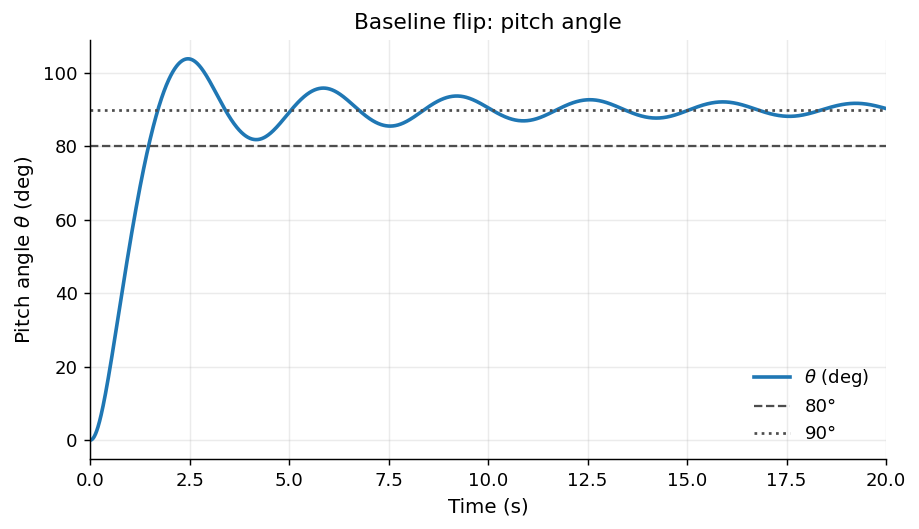

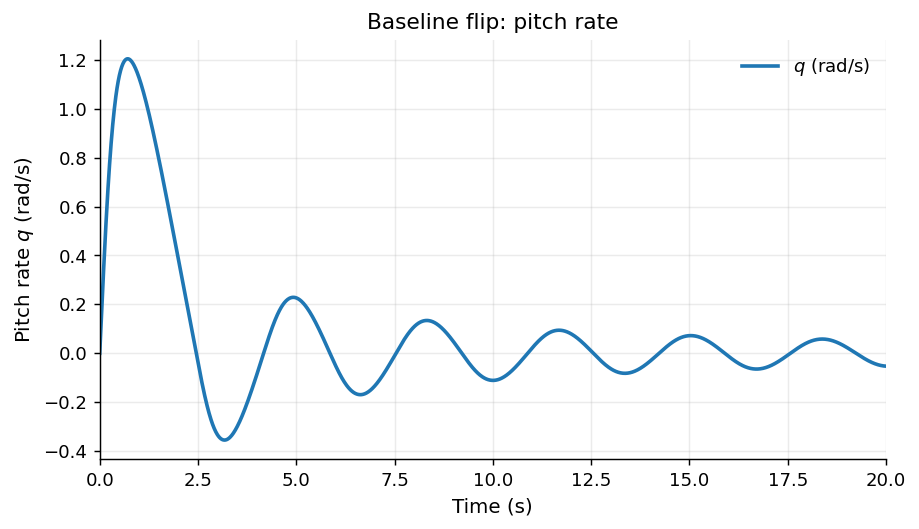

In [12]:
# --- Figure 1: theta(t) and q(t) ---
t = df["t"].to_numpy()

fig, ax = plt.subplots()
ax.plot(t, df["theta_deg"], label=r"$\theta$ (deg)")
ax.axhline(80.0, color="0.3", linestyle="--", linewidth=1.25, label="80°")
ax.axhline(90.0, color="0.3", linestyle=":", linewidth=1.5, label="90°")
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Pitch angle $\theta$ (deg)")
_finalize_ax(ax, title="Baseline flip: pitch angle")
ax.legend(frameon=False, loc="best")
fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(t, df["q"], label=r"$q$ (rad/s)")
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Pitch rate $q$ (rad/s)")
_finalize_ax(ax, title="Baseline flip: pitch rate")
ax.legend(frameon=False, loc="best")
fig.tight_layout()

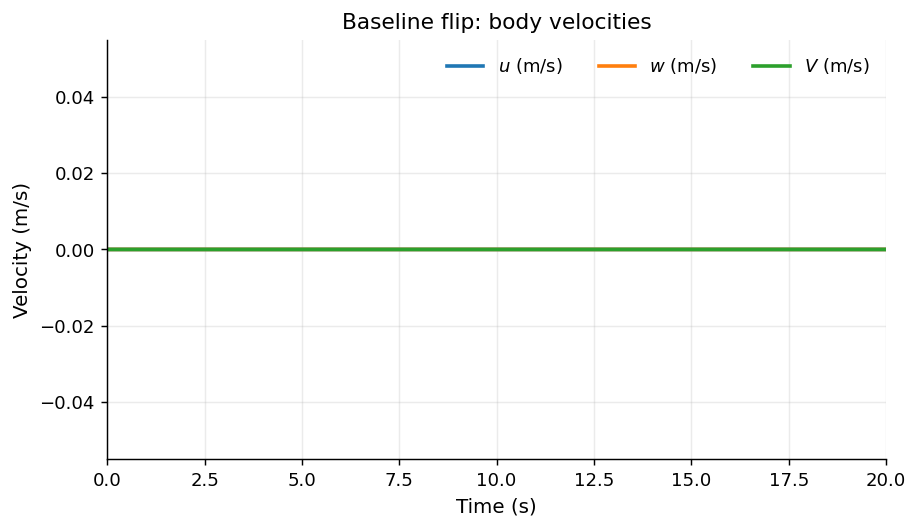

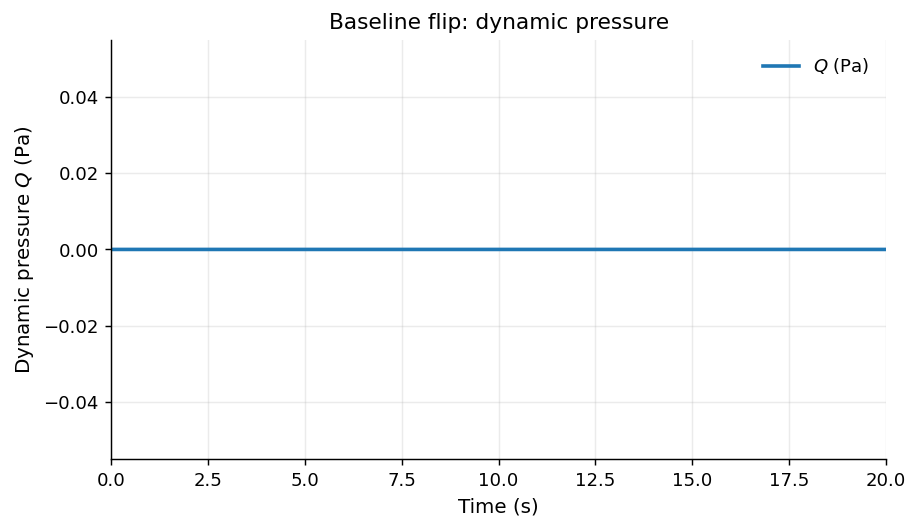

In [13]:
# --- Figure 2: velocities and dynamic pressure ---
fig, ax = plt.subplots()
ax.plot(t, df["u"], label=r"$u$ (m/s)")
ax.plot(t, df["w"], label=r"$w$ (m/s)")
ax.plot(t, df["V"], label=r"$V$ (m/s)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity (m/s)")
_finalize_ax(ax, title="Baseline flip: body velocities")
ax.legend(frameon=False, loc="best", ncols=3)
fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(t, df["Q"], label=r"$Q$ (Pa)")
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Dynamic pressure $Q$ (Pa)")
_finalize_ax(ax, title="Baseline flip: dynamic pressure")
ax.legend(frameon=False, loc="best")
fig.tight_layout()

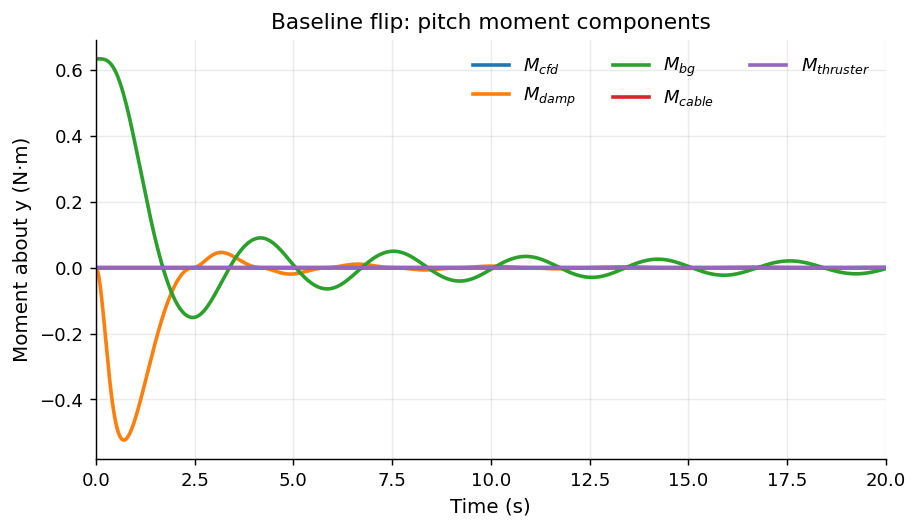

In [14]:
# --- Figure 3: moment decomposition ---
fig, ax = plt.subplots()
ax.plot(t, df["M_cfd"], label=r"$M_{cfd}$")
ax.plot(t, df["M_damp"], label=r"$M_{damp}$")
ax.plot(t, df["M_bg"], label=r"$M_{bg}$")
ax.plot(t, df["M_cable"], label=r"$M_{cable}$")
ax.plot(t, df["M_thruster"], label=r"$M_{thruster}$")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Moment about y (N·m)")
_finalize_ax(ax, title="Baseline flip: pitch moment components")
ax.legend(frameon=False, loc="best", ncols=3)
fig.tight_layout()

## Notes
- This notebook runs the full time horizon (no early termination at 80°) so you can see convergence toward the ~90° steady state.
- `df` is `result.data`: one row per `dt_out` sample; columns are diagnostics (`theta_deg`, `u`, `w`, `q`, `M_*`, etc.).
- For neutral buoyancy in this model, set `buoyancy_restore.B_mass == rigid_body.m_dry` in `configs/params_nominal.yaml` (already set in the current nominal file).